<a href="https://colab.research.google.com/github/RostislavKorst/Generative-Models-2023/blob/main/Assignment%201/1_gan_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**Autumn 2023, MSc course**


## Assignment 1

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR dataset.

Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image

%matplotlib inline
plt.style.use("ggplot")

### Define parameters & data loading

In [ ]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
sample_dir = "./images"
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

100%|██████████| 9912422/9912422 [00:00<00:00, 168757250.43it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 52553446.34it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 34427288.37it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9343074.43it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.73542482, -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.45516339,  0.58745098,  0.71973854,  0.85202616,
         0.98431373]),
 <BarContainer object of 15 artists>)

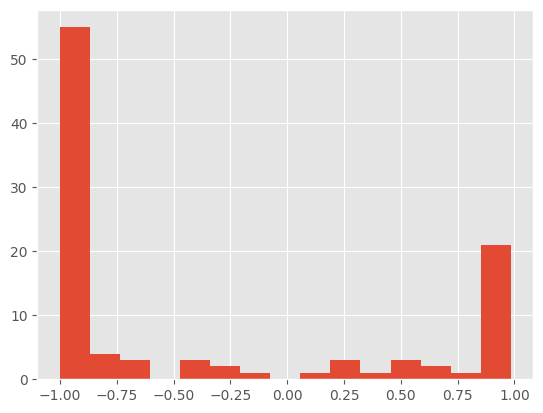

In [ ]:
img, label = mnist_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [ ]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
  return (x + 1) / 2

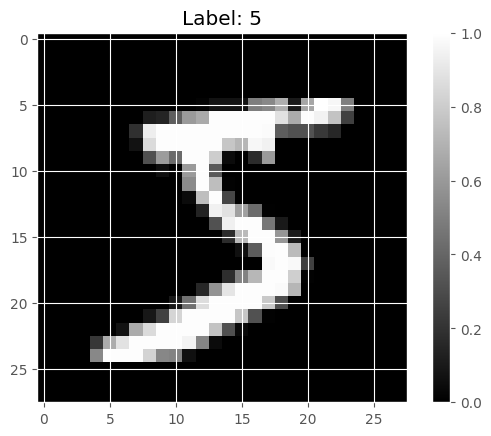

In [ ]:
# show image sample with matplotlib
denorm_img = denorm(img)
plt.imshow(denorm_img.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.colorbar()
plt.show()

In [ ]:
# define the dataloader
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(latent_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, image_size)

    def forward(self, x):
        x = nn.ReLU()(self.linear1(x))
        x = nn.ReLU()(self.linear2(x))
        x = nn.Tanh()(self.linear3(x))
        return x


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(image_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = nn.ReLU()(self.linear1(x))
        x = nn.ReLU()(self.linear2(x))
        x = nn.Sigmoid()(self.linear3(x))
        return x

### Create the Generator and Discriminator

In [ ]:
# Create a new Generator model
G = Generator(latent_size=latent_size, image_size=image_size, hidden_size=hidden_size)

# Create a new Discriminator model
D = Discriminator(image_size=image_size, hidden_size=hidden_size)

In [ ]:
# show the output of model
y = G(torch.randn(2, latent_size))
print(y)

tensor([[ 0.0680, -0.0910,  0.1112,  ..., -0.0437,  0.0891,  0.0781],

        [ 0.0804, -0.1179, -0.0375,  ..., -0.0443,  0.2454, -0.0208]],

       grad_fn=<TanhBackward0>)


In [ ]:
# define the criterion is nn.BCELoss()

import torch.optim as optim
import torch.nn as nn

# Define the loss function (criterion)
criterion = nn.BCELoss()

# Define the optimizer for the generator
optimizer_G = optim.Adam(G.parameters(), lr=LR)

# Define the optimizer for the discriminator
optimizer_D = optim.Adam(D.parameters(), lr=LR)

Discriminator Training

In [ ]:
def reset_grad():
    optimizer_G.zero_grad()
    optimizer_D.zero_grad()

def train_discriminator(D_model, G_model, images):
    # Reset gradients
    reset_grad()

    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D_model(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G_model(z)
    outputs = D_model(fake_images)
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    # Sum losses
    d_loss = real_loss + fake_loss

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    optimizer_D.step()

    return d_loss, real_score, fake_score


Generator Training

In [ ]:
def train_generator(G_model):
    # Reset gradients
    reset_grad()

    # Generate fake images and calculate loss
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1).to(device)

    # calculate the generator loss
    outputs = D(fake_images)
    g_loss = criterion(outputs, labels)

    # Backprop and optimize
    g_loss.backward()
    optimizer_G.step()

    return g_loss, fake_images


### Start the training proccess

In [ ]:
# function to save the sample output of generator
def save_fake_images_mnist(G_model, index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(
        device
    )
    fake_images = G_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [ ]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

G.to(device)
D.to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(D, G, images)

        # Train the generator
        g_loss, _ = train_generator(G)

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch + 1,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )

    # Sample and save images
    save_fake_images_mnist(G, epoch + 1)


Epoch [1/300], Step [200/600], d_loss: 1.0983, g_loss: 1.0098, D(x): 0.68, D(G(z)): 0.33

Epoch [1/300], Step [400/600], d_loss: 0.6504, g_loss: 2.7002, D(x): 0.81, D(G(z)): 0.30

Epoch [1/300], Step [600/600], d_loss: 0.8025, g_loss: 2.6067, D(x): 0.70, D(G(z)): 0.23

Saving fake_images-0001.png

Epoch [2/300], Step [200/600], d_loss: 0.5558, g_loss: 3.6179, D(x): 0.77, D(G(z)): 0.07

Epoch [2/300], Step [400/600], d_loss: 0.8124, g_loss: 1.7762, D(x): 0.71, D(G(z)): 0.25

Epoch [2/300], Step [600/600], d_loss: 0.2945, g_loss: 3.1256, D(x): 0.90, D(G(z)): 0.12

Saving fake_images-0002.png

Epoch [3/300], Step [200/600], d_loss: 2.3372, g_loss: 0.9270, D(x): 0.38, D(G(z)): 0.40

Epoch [3/300], Step [400/600], d_loss: 0.1565, g_loss: 3.2791, D(x): 0.96, D(G(z)): 0.09

Epoch [3/300], Step [600/600], d_loss: 1.0106, g_loss: 1.4308, D(x): 0.82, D(G(z)): 0.47

Saving fake_images-0003.png

Epoch [4/300], Step [200/600], d_loss: 0.3784, g_loss: 2.6105, D(x): 0.88, D(G(z)): 0.15

Epoch [4/300]

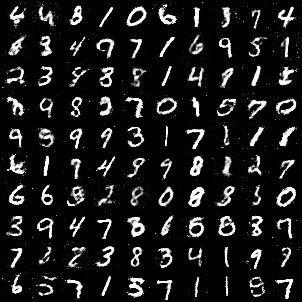

In [ ]:
# show output after epochs training
from IPython.display import Image as DisplayImage
DisplayImage(os.path.join(sample_dir, "fake_images-0225.png"))

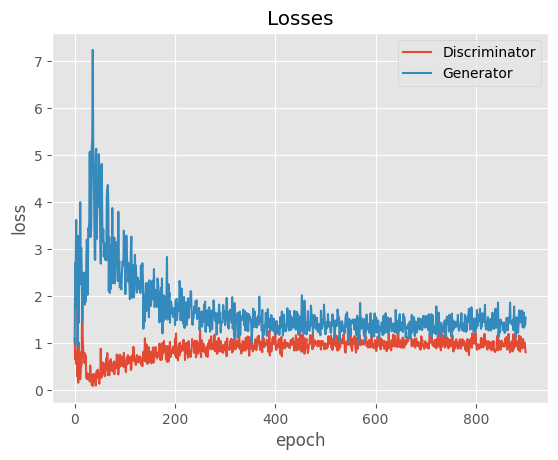

In [ ]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

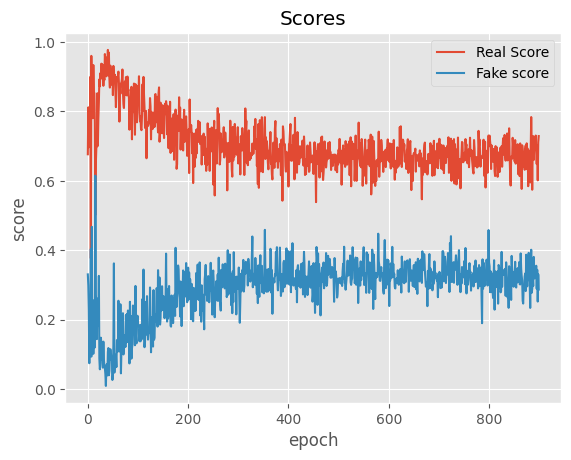

In [ ]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [ ]:
class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Files already downloaded and verified


Label:  6


(array([ 3.,  6., 52., 36.,  6.,  4., 12., 40., 40.,  7.,  2.,  6., 22.,
        32., 32.]),
 array([-0.87450981, -0.81124181, -0.74797386, -0.68470585, -0.62143791,
        -0.5581699 , -0.49490196, -0.43163398, -0.36836597, -0.305098  ,
        -0.24183004, -0.17856206, -0.11529408, -0.0520261 ,  0.01124188,
         0.07450986]),
 <BarContainer object of 15 artists>)

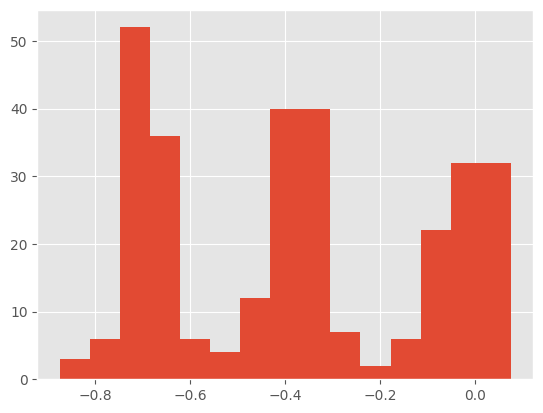

In [ ]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

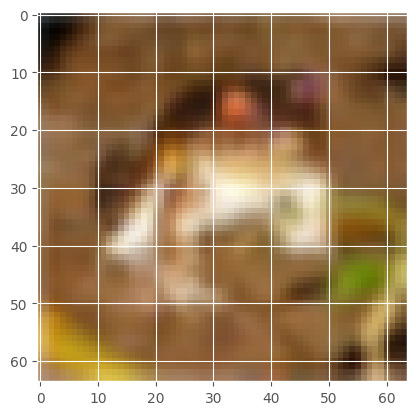

In [ ]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    return (img + 1) / 2

# show  image sample with matplotlib
img = denorm(img).numpy().transpose(1, 2, 0)
plt.imshow(img)

In [ ]:
from torch.utils.data import DataLoader

data_loader = DataLoader(
    cifar_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.workers,
    pin_memory=True
)

### DCGAN implementation

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DCGenerator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(DCGenerator, self).__init__()
        self.fc = nn.Linear(nz, ngf * 8 * 4 * 4)
        self.ngf = ngf
        self.main = nn.Sequential(
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), self.ngf * 8, 4, 4)  # Изменяем форму тензора
        return self.main(x)



class DCDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(DCDiscriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


In [ ]:
DCG = DCGenerator(nc=CFG.nc, nz=CFG.nz, ngf=CFG.ngf)
DCD = DCDiscriminator(nc=CFG.nc, ndf=CFG.ndf)

DCG.to(CFG.device)
DCD.to(CFG.device)

DCDiscriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): S

In [ ]:
y = DCG(torch.randn(2, CFG.nz).to(device))

In [ ]:
y.shape

torch.Size([2, 3, 64, 64])

In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.BCELoss()
optimizer_G = optim.Adam(DCG.parameters(), lr=CFG.lr)
optimizer_D = optim.Adam(DCD.parameters(), lr=CFG.lr)

In [ ]:
def reset_grad():
    optimizer_G.zero_grad()
    optimizer_D.zero_grad()

def train_discriminator(D_model, G_model, images, criterion, optimizer_D):
    reset_grad()
    real_labels = torch.ones(images.size(0), 1).to(CFG.device)
    outputs = D_model(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    z = torch.randn(images.size(0), CFG.nz).to(CFG.device)
    fake_images = G_model(z)
    fake_labels = torch.zeros(images.size(0), 1).to(CFG.device)
    outputs = D_model(fake_images.detach())
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_D.step()
    return d_loss, real_score, fake_score

def train_generator(D_model, G_model, criterion, optimizer_G):
    reset_grad()
    z = torch.randn(CFG.batch_size, CFG.nz).to(CFG.device)
    fake_images = G_model(z)
    labels = torch.ones(CFG.batch_size, 1).to(CFG.device)
    outputs = D_model(fake_images)
    g_loss = criterion(outputs, labels)
    g_loss.backward()
    optimizer_G.step()
    return g_loss


### Start the training proccess

In [ ]:
def save_fake_images_cifar(DCG_model, index):
    sample_vectors = torch.randn(CFG.batch_size, CFG.nz).to(CFG.device)  # Используем одномерные векторы
    fake_images = DCG_model(sample_vectors)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10)


In [ ]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.to(device)

        d_loss, real_score, fake_score = train_discriminator(DCD, DCG, images, criterion, optimizer_D)

        g_loss = train_generator(DCD, DCG, criterion, optimizer_G)

        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch + 1,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )

    # Sample and save images at the end of each epoch
    save_fake_images_cifar(DCG, epoch + 1)


Epoch [1/300], Step [200/391], d_loss: 0.0072, g_loss: 7.9798, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0001.png
Epoch [2/300], Step [200/391], d_loss: 0.0019, g_loss: 12.0777, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0002.png
Epoch [3/300], Step [200/391], d_loss: 0.0038, g_loss: 8.5693, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [4/300], Step [200/391], d_loss: 0.0198, g_loss: 7.8311, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0004.png
Epoch [5/300], Step [200/391], d_loss: 0.0014, g_loss: 9.4740, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0005.png
Epoch [6/300], Step [200/391], d_loss: 0.0090, g_loss: 8.5268, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0006.png
Epoch [7/300], Step [200/391], d_loss: 0.0050, g_loss: 8.3565, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0007.png
Epoch [8/300], Step [200/391], d_loss: 0.0254, g_loss: 9.7114, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0008.png
Epoch [9/300], Step [200/391], d_loss: 0.0073, g_loss: 8.1494, 

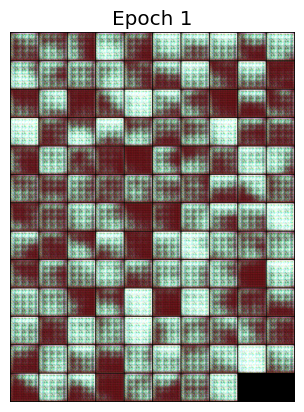

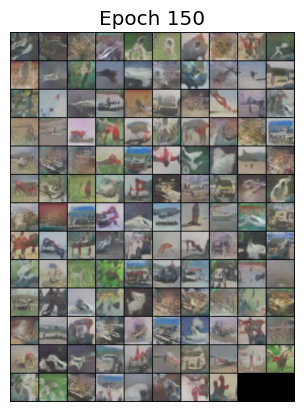

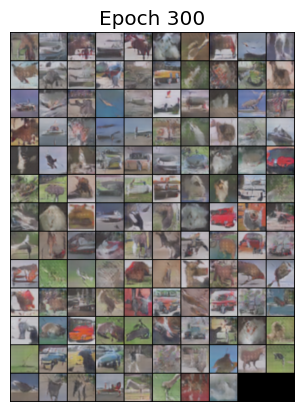

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Function to display an image
def display_image(epoch):
    file_name = f"fake_images-{epoch:04d}.png"
    image_path = os.path.join(CFG.sample_dir, file_name)

    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(f"Epoch {epoch}")
    plt.axis('off')
    plt.show()

# Display images from different epochs
display_image(1)
display_image(150)
display_image(300)